In [1]:
using CSV
using DataFrames
using LinearAlgebra
using Test
using Printf
using Statistics

┌ Info: Recompiling stale cache file /home/sturlusa/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


In [2]:
# Load data
df_henry = CSV.read("../data/henry_constants.csv")

,cage,C2H6(KH_mmol/kgPa),C2H6(err_KH_mmol/(g-bar)),CH4(KH_mmol/kgPa),CH4(err_KH_mmol/(g-bar)),CO2(KH_mmol/kgPa),CO2(err_KH_mmol/(g-bar)),H2S(KH_mmol/kgPa),H2S(err_KH_mmol/(g-bar))
1,ANUGIA_clean_iqeqcharged.cif,6.51e-5,0.0821222,9.01e-6,0.00460842,2.68e-5,0.0716555,6.48e-5,0.0953385
2,BIMDEF_clean_iqeqcharged.cif,0.00255582,38.3198,5.33e-5,0.108283,0.000632033,4.40531,0.0011429,6.22378
3,CAXVII_clean_iqeqcharged.cif,4.84e-5,0.0832867,5.84e-6,0.00724807,8.91e-5,0.694692,7.58e-5,0.564067
4,COF-102_iqeqcharged.cif,6.17e-5,0.0185726,1.08e-5,0.00184573,2.16e-5,0.00656278,4.21e-5,0.0244014
5,COF-103_iqeqcharged.cif,4.68e-5,0.0178347,9.56e-6,0.000785383,1.87e-5,0.00325894,3.48e-5,0.0123159
6,COF-105_iqeqcharged.cif,1.85e-5,0.00631065,7.04e-6,0.000213307,1.21e-5,0.00187831,1.78e-5,0.00274876
7,COF-108_iqeqcharged.cif,2.43e-5,0.0161306,7.82e-6,0.00258108,1.44e-5,0.0130927,2.28e-5,0.0258468
8,FIQCEN_clean_iqeqcharged.cif,0.000765784,6.0664,1.87e-5,0.0158901,6.24e-5,0.248288,0.000531858,2.23324
9,HOGLEV_clean_iqeqcharged.cif,0.000221831,0.198978,1.47e-5,0.00713184,9.88e-5,0.250357,0.000275242,0.47059
10,KAMZUV_clean5b_iqeqcharged.cif,5.0e-5,0.12805,6.04e-6,0.00475795,1.45e-5,0.0648801,3.3e-5,0.123196


In [17]:
function perform_svd(gas1::AbstractString, gas2::AbstractString)
    N = length(df_henry[1])
    sigma = zeros(N, N, 2)
    
    for i = 1:N
        for j = i+1:N
            H = make_h_matrix(i, j, gas1, gas2)
            H⁻¹ = inv(H)
            F = svd(H⁻¹)
            sigma[i, j, :] = F.S
        end
    end
    return sigma
end

perform_svd (generic function with 1 method)

In [14]:
function make_h_matrix(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = zeros(2,2)
    H[1, 1] = df_henry[mof1, Symbol(gas1 * "(KH_mmol/kgPa)")] - df_henry[mof1, Symbol("CH4(KH_mmol/kgPa)")]
    H[1, 2] = df_henry[mof1, Symbol(gas2 * "(KH_mmol/kgPa)")] - df_henry[mof1, Symbol("CH4(KH_mmol/kgPa)")]
    H[2, 1] = df_henry[mof2, Symbol(gas1 * "(KH_mmol/kgPa)")] - df_henry[mof2, Symbol("CH4(KH_mmol/kgPa)")]
    H[2, 2] = df_henry[mof2, Symbol(gas2 * "(KH_mmol/kgPa)")] - df_henry[mof2, Symbol("CH4(KH_mmol/kgPa)")]
    return H
end

make_h_matrix (generic function with 2 methods)

In [5]:
function analyze_svd(sigma::Array{Float64, 3})
    best_id = argmax(sigma[:, :, 2])
    worst_id = argmin(sigma[:, :, 1])
    
    MOF_best1 = String(df_henry[best_id[1], 1])
    MOF_best2 = String(df_henry[best_id[2], 1])
    
    @printf("The most sensitive pair of MOFs is %s and %s\n", MOF_best1, MOF_best2)
    
    MOF_worst1 = String(df_henry[worst_id[1], 1])
    MOF_worst2 = String(df_henry[worst_id[2], 1])
    
    @printf("The least sensitive pair of MOFs is %s and %s\n", MOF_worst1, MOF_worst2)
end

analyze_svd (generic function with 1 method)

In [19]:
using PyPlot
import PyPlot; const plt = PyPlot

function plot_graphs(mof1::Int, mof2::Int, gas1::AbstractString, gas2::AbstractString)
    H = make_h_matrix(mof1, mof2, gas1, gas2)
    H⁻¹ = inv(H)
    F = svd(H⁻¹)
    θ = range(0, stop=2*π, length=500)[1:end-1]
    p = transpose(hcat(cos.(θ), sin.(θ))) # set pt change
    n = H⁻¹ * p # required input

    S = perform_svd(gas1, gas2)
    biggest_σ = maximum(S[:, :, 1]) 

    function plot_vector(x; head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        arrow(0, 0, x_plot[1], x_plot[2], head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        text(x_label[1], x_label[2], label)
    end

    cnorm = PyPlot.matplotlib[:colors][:Normalize](vmin=0.0, vmax=2 * π)

    m = plt.cm[:ScalarMappable](norm=cnorm, cmap=plt.cm[:hsv])
    m[:set_array]([]) # trick


    figure(figsize=(11, 5))
    subplot(121, aspect="equal")
    for i = 1:length(θ)-1
        plt.plot(p[1, i:i+1], p[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    xlim([-1.1, 1.1])
    ylim([-1.1, 1.1])
    axis("equal")
    xlabel(@sprintf("\$p_{%s}^*\$ (bar)", gas1))
    ylabel(@sprintf("\$p_{%s}^*\$ (bar)", gas2))
    for k = 1:2
        plot_vector(F.V[:, k], color="k",
            label="\$\\mathbf{v}_$k\$", label_dist=0.1)
    end
    title("Composition Space")
    tight_layout()

    subplot(122, aspect="equal")
    ylim([-biggest_σ, biggest_σ])
    xlim([-biggest_σ, biggest_σ])
    for i = 1:length(θ)-1 
        plt.plot(n[1, i:i+1], n[2, i:i+1], lw=5, c=m[:to_rgba](mean(θ[i:i+1])))
    end
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k], head_length=0.005,
            head_width=0.05/3, color="k", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.025)
    end
    axis("equal")
    xlabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof1))
    ylabel(@sprintf("\$n_{%i}^*\$ (mmol of total gas)", mof2))
    title("Response Space")
    tight_layout()
    savefig(@sprintf("composition_response_of_%i_and_%i.png", mof1, mof2), format="png", dpi=300)
end

plot_graphs (generic function with 1 method)

In [20]:
@testset "Sensor Tests" begin
    H = make_h_matrix(3, 5, "CO2", "C2H6")
    G = [(8.91e-5) (4.84e-5); (1.87e-5) (4.68e-5)] .- [5.84e-6; 9.56e-6]
    @test isapprox(H, G)
end

Test Summary: | Pass  Total
Sensor Tests  |    1      1


Test.DefaultTestSet("Sensor Tests", Any[], 1, false)

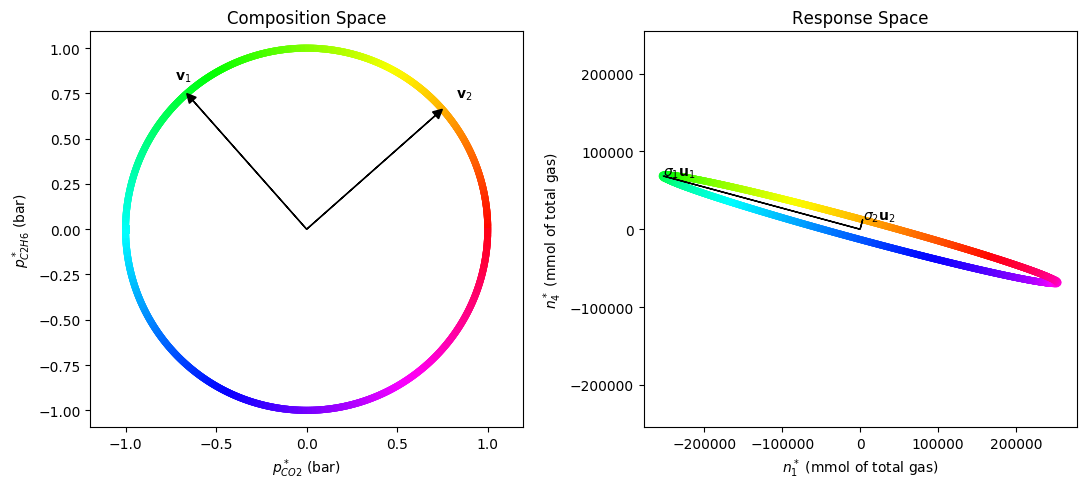

In [21]:
plot_graphs(1,4,"CO2","C2H6")